![for sale image, from https://time.com/5835778/selling-home-coronavirus/](https://api.time.com/wp-content/uploads/2020/05/selling-home-coronavirus.jpg?w=800&quality=85)

# Project Title

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Questions to consider:

- Who are your stakeholders?
- What are your stakeholders' pain points related to this project?
- Why are your predictions important from a business perspective?

### Stakeholders: small real estate company who advises families on selling their homes
### Pain points: 

## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

In [831]:
# import relevant libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [832]:
data = pd.read_csv('../../data/kc_house_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [833]:
data.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [834]:
data.drop_duplicates(subset='id', inplace=True)

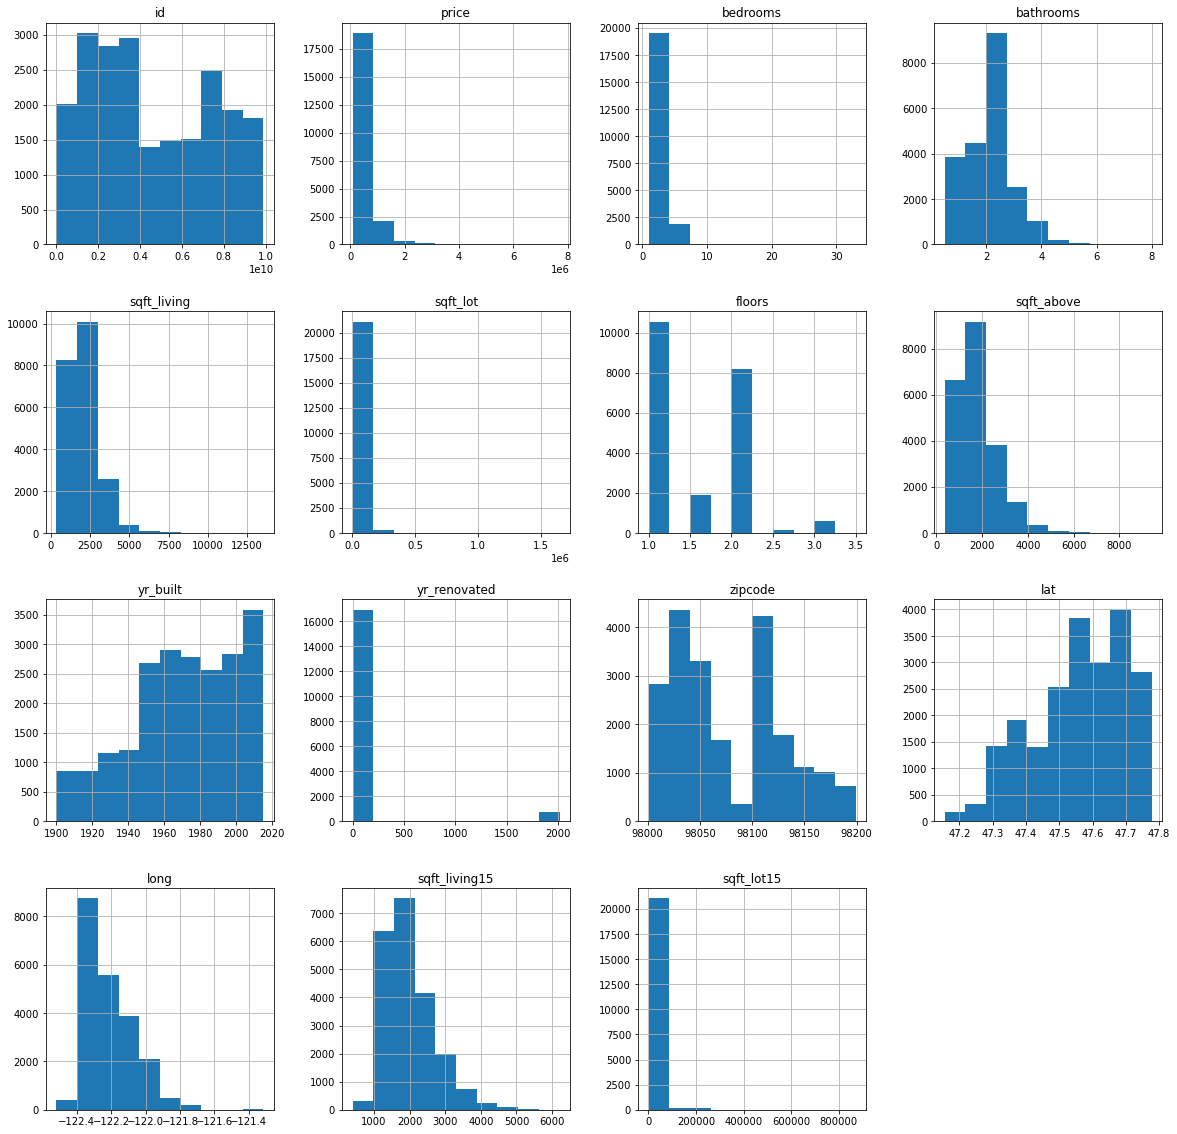

In [835]:
data.hist(figsize=(20,20));

Some of these features look like they could use some log processing.

In [836]:
datalog = pd.DataFrame()
log_cols = ['id','price','sqft_living','sqft_lot','sqft_above']
for col in log_cols:
    if col == 'id':
        datalog[col] = data[col]
        continue
    datalog[f'{col}_log'] = data[col].map(lambda x: np.log(x))

In [837]:
data = pd.merge(data,datalog,on='id')

In [838]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price_log',
       'sqft_living_log', 'sqft_lot_log', 'sqft_above_log'],
      dtype='object')

In [839]:
data['sqft_basement'].value_counts()

0.0       12717
?           452
600.0       216
500.0       206
700.0       205
          ...  
2730.0        1
243.0         1
1852.0        1
415.0         1
172.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [840]:
data.loc[data['sqft_basement'] == '?','sqft_basement'] = np.nan

In [841]:
data['sqft_basement'].value_counts()

0.0       12717
600.0       216
500.0       206
700.0       205
800.0       201
          ...  
2730.0        1
243.0         1
1852.0        1
415.0         1
172.0         1
Name: sqft_basement, Length: 303, dtype: int64

In [842]:
def tryfloat(x):
    try:
        return float(x)
    except:
        return x

In [843]:
data['sqft_basement'] = data['sqft_basement'].map(tryfloat)

In [844]:
rel_cols = ['price', 'price_log', 'grade', 'condition', 'view', 'sqft_living',
            'sqft_living_log', 'sqft_lot', 'sqft_lot_log', 'sqft_above', 'sqft_above_log',
            'sqft_basement', 'bedrooms', 'bathrooms', 'floors']
data = data[rel_cols]

In [845]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21419
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            21420 non-null  float64
 1   price_log        21420 non-null  float64
 2   grade            21420 non-null  object 
 3   condition        21420 non-null  object 
 4   view             21357 non-null  object 
 5   sqft_living      21420 non-null  int64  
 6   sqft_living_log  21420 non-null  float64
 7   sqft_lot         21420 non-null  int64  
 8   sqft_lot_log     21420 non-null  float64
 9   sqft_above       21420 non-null  int64  
 10  sqft_above_log   21420 non-null  float64
 11  sqft_basement    20968 non-null  float64
 12  bedrooms         21420 non-null  int64  
 13  bathrooms        21420 non-null  float64
 14  floors           21420 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 2.6+ MB


In [846]:
data.describe()

,price,price_log,sqft_living,sqft_living_log,sqft_lot,sqft_lot_log,sqft_above,sqft_above_log,sqft_basement,bedrooms,bathrooms,floors
count,2.142000e+04,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000,21420.000000,21420.000000,20968.000000,21420.000000,21420.000000,21420.000000
mean,5.407393e+05,13.048915,2083.132633,7.552148,1.512804e+04,8.989676,1791.170215,7.396578,292.067484,3.373950,2.118429,1.495985
std,3.679311e+05,0.526726,918.808412,0.424047,4.153080e+04,0.903854,828.692965,0.427241,442.697190,0.925405,0.768720,0.540081
min,7.800000e+04,11.264464,370.000000,5.913503,5.200000e+02,6.253829,370.000000,5.913503,0.000000,1.000000,0.500000,1.000000
25%,3.225000e+05,12.683858,1430.000000,7.265430,5.040000e+03,8.525161,1200.000000,7.090077,0.000000,3.000000,1.750000,1.000000
50%,4.500000e+05,13.017003,1920.000000,7.560080,7.614000e+03,8.937744,1560.000000,7.352441,0.000000,3.000000,2.250000,1.500000
75%,6.450000e+05,13.377006,2550.000000,7.843849,1.069050e+04,9.277111,2220.000000,7.705262,560.000000,4.000000,2.500000,2.000000
max,7.700000e+06,15.856731,13540.000000,9.513404,1.651359e+06,14.317109,9410.000000,9.149528,4820.000000,33.000000,8.000000,3.500000


In [847]:
data['view'].value_counts()

NONE         19253
AVERAGE        956
GOOD           505
FAIR           329
EXCELLENT      314
Name: view, dtype: int64

In [848]:
data['view'].value_counts()[0]/len(data)

0.8988328664799253

In [849]:
# delete 'view' column since not much information given
data.drop(columns='view', inplace=True)

In [850]:
for col in data.columns:
    print(f'\n{col}:\n')
    print(data.sort_values(by=col,ascending=False).head(15))


price:

           price  price_log         grade condition  sqft_living  \
7187   7700000.0  15.856731    13 Mansion      Good        12050   
3877   7060000.0  15.769956  11 Excellent   Average        10040   
9170   6890000.0  15.745582    13 Mansion   Average         9890   
4371   5570000.0  15.532906    13 Mansion   Average         9200   
1434   5350000.0  15.492607     12 Luxury   Average         8000   
1301   5300000.0  15.483217     12 Luxury      Good         7390   
1152   5110000.0  15.446710     12 Luxury   Average         8010   
8023   4670000.0  15.356670     12 Luxury   Average         9640   
2601   4500000.0  15.319588     12 Luxury   Average         6640   
8560   4490000.0  15.317363     12 Luxury   Average         6430   
12249  4210000.0  15.252973     12 Luxury   Average         7440   
4110   4000000.0  15.201805     12 Luxury   Average         7080   
2066   3850000.0  15.163584  11 Excellent      Good         5770   
6972   3800000.0  15.150512    13 Mansi

           price  price_log         grade  condition  sqft_living  \
16354   360000.0  12.793859     7 Average  Very Good         1630   
3360    579000.0  13.269058     7 Average  Very Good         1760   
11240   651500.0  13.387033     7 Average  Very Good         1500   
12289   570000.0  13.253392     7 Average  Very Good         2340   
19375  1360000.0  14.122995  10 Very Good  Very Good         4270   
6455   1240000.0  14.030622      9 Better  Very Good         3330   
12290   661254.0  13.401893     7 Average  Very Good         2290   
5062    549000.0  13.215854     7 Average  Very Good         1340   
19373   724950.0  13.493858        8 Good  Very Good         1960   
5060    619000.0  13.335861        8 Good  Very Good         2300   
1577    500000.0  13.122363     7 Average  Very Good         1620   
14461   570000.0  13.253392     7 Average  Very Good         2460   
14861  1110000.0  13.919871      9 Better  Very Good         2740   
9215    560000.0  13.235692     7 

           price  price_log         grade condition  sqft_living  \
12651  2280000.0  14.639686     12 Luxury   Average        13540   
9170   6890000.0  15.745582    13 Mansion   Average         9890   
7187   7700000.0  15.856731    13 Mansion      Good        12050   
18125  3300000.0  15.009433  11 Excellent   Average         8020   
13279  2420000.0  14.699278    13 Mansion   Average         7880   
19671  2700000.0  14.808762     12 Luxury   Average         7850   
3877   7060000.0  15.769956  11 Excellent   Average        10040   
11756  1950000.0  14.483340     12 Luxury   Average         7420   
18415  1140000.0  13.946539  11 Excellent   Average         7320   
1434   5350000.0  15.492607     12 Luxury   Average         8000   
16610  1920000.0  14.467836     12 Luxury   Average         7730   
10998  1820000.0  14.414347     12 Luxury   Average         6640   
20263  1600000.0  14.285514  11 Excellent   Average         6530   
8560   4490000.0  15.317363     12 Luxury   Aver

33 bedrooms is pretty crazy and not highly correlated with a high price. I'll remove that one.

In [851]:
data = data[data['bedrooms'] != 33]

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


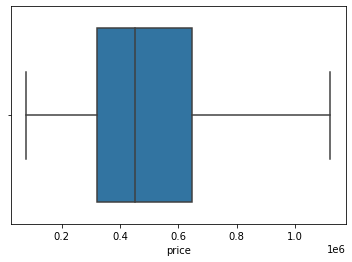

In [852]:
sns.boxplot(data['price'], orient='h', showfliers=False);

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


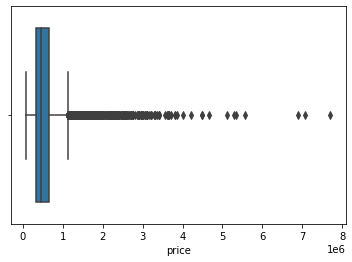

In [853]:
sns.boxplot(data['price'], orient='h');

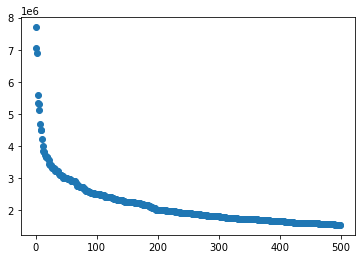

In [854]:
fig, ax = plt.subplots()
ax.scatter(x=range(500), y=data.sort_values('price', ascending=False)['price'][:500])

In [855]:
# homes >= $2 mil are significant outliers, we'll remove them
# Only account for 0.95% of all the data
len(data[data['price'] >= 2000000])/len(data)

0.009711004248564359

In [856]:
len(data)

21419

In [857]:
data = data[data['price'] < 2000000]

In [858]:
len(data)

21211

In [859]:
# sns.pairplot(data);

In [860]:
data.corr()

,price,price_log,sqft_living,sqft_living_log,sqft_lot,sqft_lot_log,sqft_above,sqft_above_log,sqft_basement,bedrooms,bathrooms,floors
price,1.000000,0.941537,0.679370,0.629791,0.097156,0.145628,0.584342,0.552887,0.285677,0.325003,0.508784,0.278395
price_log,0.941537,1.000000,0.666314,0.655003,0.097791,0.119942,0.569866,0.563827,0.285809,0.338821,0.522754,0.306533
sqft_living,0.679370,0.666314,1.000000,0.962572,0.174213,0.340383,0.867864,0.845020,0.404472,0.598497,0.742126,0.352524
sqft_living_log,0.629791,0.655003,0.962572,1.000000,0.148557,0.318594,0.827452,0.859608,0.404348,0.635979,0.752694,0.361452
sqft_lot,0.097156,0.097791,0.174213,0.148557,1.000000,0.640746,0.183254,0.161812,0.011801,0.033468,0.085077,-0.008236
sqft_lot_log,0.145628,0.119942,0.340383,0.318594,0.640746,1.000000,0.324267,0.310798,0.084036,0.186121,0.085292,-0.245445
sqft_above,0.584342,0.569866,0.867864,0.827452,0.183254,0.324267,1.000000,0.966671,-0.102822,0.487111,0.668839,0.527447
sqft_above_log,0.552887,0.563827,0.845020,0.859608,0.161812,0.310798,0.966671,1.000000,-0.087321,0.524653,0.684475,0.545480
sqft_basement,0.285677,0.285809,0.404472,0.404348,0.011801,0.084036,-0.102822,-0.087321,1.000000,0.301585,0.254192,-0.264540
bedrooms,0.325003,0.338821,0.598497,0.635979,0.033468,0.186121,0.487111,0.524653,0.301585,1.000000,0.521798,0.176726


In [861]:
data.columns

Index(['price', 'price_log', 'grade', 'condition', 'sqft_living',
       'sqft_living_log', 'sqft_lot', 'sqft_lot_log', 'sqft_above',
       'sqft_above_log', 'sqft_basement', 'bedrooms', 'bathrooms', 'floors'],
      dtype='object')

In [862]:
# fig, axes = plt.subplots(5,3, figsize=(20,20))
# for i, col in enumerate(data.columns):
#     sns.histplot(data=data, x=col, kde=True, ax=axes[i//3,i%3]);

### Categorical: 'Grade' to only 4: Low, Average, Above Average, and Excellent

In [863]:
# Lows including 3 Poor, 5 Fair and 6 Low Average
data['grade'].replace('3 Poor','G_Low', inplace=True)
data['grade'].replace('5 Fair','G_Low', inplace=True)
data['grade'].replace('4 Low','G_Low', inplace=True)
data['grade'].replace('6 Low Average','G_Low', inplace=True)

# Average including 7 Average 
data['grade'].replace('7 Average','G_Average', inplace=True)

# Average Above including 8 Good,9 Better
data['grade'].replace('8 Good','G_Above_Ave', inplace=True)
data['grade'].replace('9 Better','G_Above_Ave', inplace=True)

# Excellent including 10 Very Good, 11 Excellent,12 Luxury and 13 Mansion
data['grade'].replace('10 Very Good','G_Excellent', inplace=True)
data['grade'].replace('11 Excellent','G_Excellent', inplace=True)
data['grade'].replace('12 Luxury','G_Excellent', inplace=True)
data['grade'].replace('13 Mansion','G_Excellent', inplace=True)

In [864]:
data['grade'].value_counts(normalize=True)

G_Average      0.418981
G_Above_Ave    0.406487
G_Low          0.106407
G_Excellent    0.068125
Name: grade, dtype: float64

### Categorical: 'Condition' to only 3: Low, Average, and Good

In [865]:
data['condition'].value_counts(normalize=True)

Average      0.649239
Good         0.263778
Very Good    0.078073
Fair         0.007590
Poor         0.001320
Name: condition, dtype: float64

In [866]:
# Poor including Poor and Fair
data['condition'].replace('Poor','Cond_Poor', inplace=True)
data['condition'].replace('Fair','Cond_Poor', inplace=True)


#Average staying the same
data['condition'].replace('Average','Cond_Ave', inplace=True)

# Good including Good and VeryGood
data['condition'].replace('Good','Cond_Good', inplace=True)
data['condition'].replace('Very Good','Cond_Good', inplace=True)

data['condition'].value_counts(normalize=True)

Cond_Ave     0.649239
Cond_Good    0.341851
Cond_Poor    0.008910
Name: condition, dtype: float64

In [867]:
data.groupby(by=['condition','grade']).agg(['mean','count'])['price']

mean  count
condition grade                           
Cond_Ave  G_Above_Ave  5.760543e+05   6267
          G_Average    3.848600e+05   5172
          G_Excellent  1.041862e+06   1218
          G_Low        2.850692e+05   1114
Cond_Good G_Above_Ave  6.922039e+05   2338
          G_Average    4.274453e+05   3637
          G_Excellent  1.187174e+06    226
          G_Low        3.087356e+05   1050
Cond_Poor G_Above_Ave  5.165265e+05     17
          G_Average    3.332941e+05     78
          G_Excellent  9.500000e+05      1
          G_Low        2.569839e+05     93

In [868]:
data.groupby(by=['grade','condition']).agg(['mean','count'])['price']

mean  count
grade       condition                     
G_Above_Ave Cond_Ave   5.760543e+05   6267
            Cond_Good  6.922039e+05   2338
            Cond_Poor  5.165265e+05     17
G_Average   Cond_Ave   3.848600e+05   5172
            Cond_Good  4.274453e+05   3637
            Cond_Poor  3.332941e+05     78
G_Excellent Cond_Ave   1.041862e+06   1218
            Cond_Good  1.187174e+06    226
            Cond_Poor  9.500000e+05      1
G_Low       Cond_Ave   2.850692e+05   1114
            Cond_Good  3.087356e+05   1050
            Cond_Poor  2.569839e+05     93

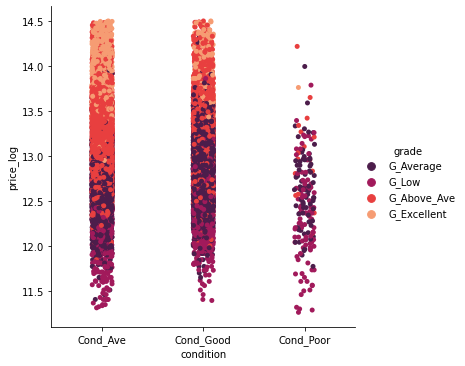

In [874]:
sns.catplot(x='condition',y='price_log', hue = "grade", data=data, palette="rocket")

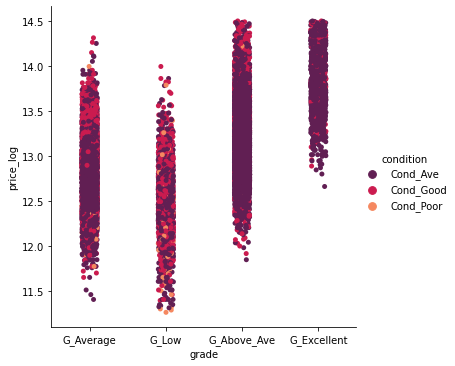

In [875]:
sns.catplot(x='grade',y='price_log', hue = "condition", data=data, palette="rocket")

In [876]:
cond = data[["condition"]]
ohe = OneHotEncoder(categories="auto", handle_unknown="error", sparse=False)
ohe.fit(cond)
cond_encod = ohe.transform(cond)
cond_encod = pd.DataFrame(
    # Pass in NumPy array
    cond_encod,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index= data.index
)
cond_encod.drop(columns='Cond_Ave', inplace=True)

In [877]:
grade = data[["grade"]]
ohe = OneHotEncoder(categories="auto",handle_unknown="ignore", sparse=False)
ohe.fit(grade)
grade_encod = ohe.transform(grade)
grade_encod = pd.DataFrame(
    # Pass in NumPy array
    grade_encod,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index= data.index
)
grade_encod.drop(columns='G_Average', inplace=True)

In [878]:
data = pd.concat([data, cond_encod, grade_encod], axis=1)\
        .drop(columns=['condition','grade'])

### Changing sqft_basement to a binomial variable "has_basement"

In [879]:
# replace sqft_basement with basement: True (1) / False (0)
data['sqft_basement'] = data['sqft_basement'].map(lambda x: 1 if x > 0 else 0)
data.rename(columns={'sqft_basement':'has_basement'}, inplace=True)

In [880]:
data

,price,price_log,sqft_living,sqft_living_log,sqft_lot,sqft_lot_log,sqft_above,sqft_above_log,has_basement,bedrooms,bathrooms,floors,Cond_Good,Cond_Poor,G_Above_Ave,G_Excellent,G_Low
0,221900.0,12.309982,1180,7.073270,5650,8.639411,1180,7.073270,0,3,1.00,1.0,0.0,0.0,0.0,0.0,0.0
1,538000.0,13.195614,2570,7.851661,7242,8.887653,2170,7.682482,1,3,2.25,2.0,0.0,0.0,0.0,0.0,0.0
2,180000.0,12.100712,770,6.646391,10000,9.210340,770,6.646391,0,2,1.00,1.0,0.0,0.0,0.0,0.0,1.0
3,604000.0,13.311329,1960,7.580700,5000,8.517193,1050,6.956545,1,4,3.00,1.0,1.0,0.0,0.0,0.0,0.0
4,510000.0,13.142166,1680,7.426549,8080,8.997147,1680,7.426549,0,3,2.00,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,360000.0,12.793859,1530,7.333023,1131,7.030857,1530,7.333023,0,3,2.50,3.0,0.0,0.0,1.0,0.0,0.0
21416,400000.0,12.899220,2310,7.745003,5813,8.667852,2310,7.745003,0,4,2.50,2.0,0.0,0.0,1.0,0.0,0.0
21417,402101.0,12.904459,1020,6.927558,1350,7.207860,1020,6.927558,0,2,0.75,2.0,0.0,0.0,0.0,0.0,0.0
21418,400000.0,12.899220,1600,7.377759,2388,7.778211,1600,7.377759,0,3,2.50,2.0,0.0,0.0,1.0,0.0,0.0


In [881]:
data.corr()

,price,price_log,sqft_living,sqft_living_log,sqft_lot,sqft_lot_log,sqft_above,sqft_above_log,has_basement,bedrooms,bathrooms,floors,Cond_Good,Cond_Poor,G_Above_Ave,G_Excellent,G_Low
price,1.000000,0.941537,0.679370,0.629791,0.097156,0.145628,0.584342,0.552887,0.175257,0.325003,0.508784,0.278395,0.000315,-0.067465,0.255133,0.515070,-0.270319
price_log,0.941537,1.000000,0.666314,0.655003,0.097791,0.119942,0.569866,0.563827,0.197646,0.338821,0.522754,0.306533,-0.006372,-0.098097,0.341057,0.427027,-0.357206
sqft_living,0.679370,0.666314,1.000000,0.962572,0.174213,0.340383,0.867864,0.845020,0.189572,0.598497,0.742126,0.352524,-0.097081,-0.073579,0.319024,0.518781,-0.356622
sqft_living_log,0.629791,0.655003,0.962572,1.000000,0.148557,0.318594,0.827452,0.859608,0.223714,0.635979,0.752694,0.361452,-0.086061,-0.090634,0.383171,0.421951,-0.447542
sqft_lot,0.097156,0.097791,0.174213,0.148557,1.000000,0.640746,0.183254,0.161812,-0.036467,0.033468,0.085077,-0.008236,0.005210,0.039408,0.013346,0.114777,-0.008638
sqft_lot_log,0.145628,0.119942,0.340383,0.318594,0.640746,1.000000,0.324267,0.310798,-0.054065,0.186121,0.085292,-0.245445,0.113461,0.043159,-0.029005,0.207617,-0.004090
sqft_above,0.584342,0.569866,0.867864,0.827452,0.183254,0.324267,1.000000,0.966671,-0.235504,0.487111,0.668839,0.527447,-0.194130,-0.063937,0.315555,0.525435,-0.313507
sqft_above_log,0.552887,0.563827,0.845020,0.859608,0.161812,0.310798,0.966671,1.000000,-0.231910,0.524653,0.684475,0.545480,-0.182504,-0.076013,0.387245,0.439025,-0.391505
has_basement,0.175257,0.197646,0.189572,0.223714,-0.036467,-0.054065,-0.235504,-0.231910,1.000000,0.154750,0.149617,-0.260286,0.121244,-0.019809,0.024901,-0.011508,-0.122098
bedrooms,0.325003,0.338821,0.598497,0.635979,0.033468,0.186121,0.487111,0.524653,0.154750,1.000000,0.521798,0.176726,0.003144,-0.059082,0.189321,0.178162,-0.279978


In [882]:
datafeat = data.drop(columns=['price','price_log'])
datafeat.corr()

,sqft_living,sqft_living_log,sqft_lot,sqft_lot_log,sqft_above,sqft_above_log,has_basement,bedrooms,bathrooms,floors,Cond_Good,Cond_Poor,G_Above_Ave,G_Excellent,G_Low
sqft_living,1.000000,0.962572,0.174213,0.340383,0.867864,0.845020,0.189572,0.598497,0.742126,0.352524,-0.097081,-0.073579,0.319024,0.518781,-0.356622
sqft_living_log,0.962572,1.000000,0.148557,0.318594,0.827452,0.859608,0.223714,0.635979,0.752694,0.361452,-0.086061,-0.090634,0.383171,0.421951,-0.447542
sqft_lot,0.174213,0.148557,1.000000,0.640746,0.183254,0.161812,-0.036467,0.033468,0.085077,-0.008236,0.005210,0.039408,0.013346,0.114777,-0.008638
sqft_lot_log,0.340383,0.318594,0.640746,1.000000,0.324267,0.310798,-0.054065,0.186121,0.085292,-0.245445,0.113461,0.043159,-0.029005,0.207617,-0.004090
sqft_above,0.867864,0.827452,0.183254,0.324267,1.000000,0.966671,-0.235504,0.487111,0.668839,0.527447,-0.194130,-0.063937,0.315555,0.525435,-0.313507
sqft_above_log,0.845020,0.859608,0.161812,0.310798,0.966671,1.000000,-0.231910,0.524653,0.684475,0.545480,-0.182504,-0.076013,0.387245,0.439025,-0.391505
has_basement,0.189572,0.223714,-0.036467,-0.054065,-0.235504,-0.231910,1.000000,0.154750,0.149617,-0.260286,0.121244,-0.019809,0.024901,-0.011508,-0.122098
bedrooms,0.598497,0.635979,0.033468,0.186121,0.487111,0.524653,0.154750,1.000000,0.521798,0.176726,0.003144,-0.059082,0.189321,0.178162,-0.279978
bathrooms,0.742126,0.752694,0.085077,0.085292,0.668839,0.684475,0.149617,0.521798,1.000000,0.504878,-0.183144,-0.085909,0.378187,0.364774,-0.405277
floors,0.352524,0.361452,-0.008236,-0.245445,0.527447,0.545480,-0.260286,0.176726,0.504878,1.000000,-0.313795,-0.058180,0.353925,0.212181,-0.247233


In [931]:
data.corr().abs().sort_values('price_log',ascending=False)['price_log']

price_log                       1.000000
price                           0.941537
sqft_living                     0.666314
sqft_living_log                 0.655003
sqft_above                      0.569866
sqft_above_log                  0.563827
bathrooms                       0.522754
bathrooms/sqft_living_log       0.470204
G_Excellent                     0.427027
G_Low                           0.357206
G_Above_Ave                     0.341057
bedrooms                        0.338821
floors                          0.306533
sqft_living_log/sqft_lot_log    0.263774
bedroom/sqft_living_log         0.232930
has_basement*sqft_living_log    0.218246
floors/sqft_living_log          0.215726
has_basement                    0.197646
sqft_lot_log                    0.119942
Cond_Poor                       0.098097
sqft_lot                        0.097791
Cond_Good                       0.006372
Name: price_log, dtype: float64

In [935]:
topcorr = data.corr().abs().sort_values('price_log',ascending=False)['price_log']
tcv = topcorr.values.reshape(-1,1)
tcf = pd.DataFrame(tcv, index=topcorr.index)

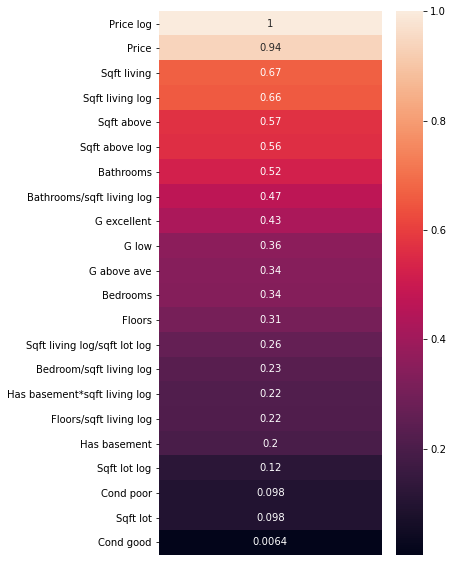

In [961]:
fig, ax = plt.subplots(figsize=(3,6))
sns.heatmap(tcf, annot=True, yticklabels=1, xticklabels=False, ax=ax)
ylabels = [item.capitalize() for item in tcf.index]
ylabels = [item.split('_') for item in ylabels]
ylabels = [' '.join(item) for item in ylabels]
ax.set_yticklabels(ylabels);

In [884]:
datafeat = data.drop(columns=['price_log','price'])
dtfc = datafeat.corr().abs().stack().reset_index().sort_values(0, ascending=False)

dtfc['col_pairs'] = list(zip(dtfc.level_0,dtfc.level_1))
dtfc['same'] = dtfc['col_pairs'].map(lambda x: (x[0] in x[1]) or (x[1] in x[0]))
dtfc['col_pairs'] = dtfc['col_pairs'].map(lambda x:sorted(list(x)))
dtfc.set_index(['col_pairs'],inplace=True)
dtfc = dtfc[dtfc['same'] == False]
dtfc.drop(columns=['level_0','level_1','same'],inplace=True)
dtfc.columns = ['C']
dtfc.drop_duplicates(inplace=True)
dtfc.head(20)

,C
col_pairs,
"[sqft_above, sqft_living]",0.867864
"[sqft_above_log, sqft_living_log]",0.859608
"[sqft_above_log, sqft_living]",0.845020
"[sqft_above, sqft_living_log]",0.827452
"[bathrooms, sqft_living_log]",0.752694
"[bathrooms, sqft_living]",0.742126
"[bathrooms, sqft_above_log]",0.684475
"[bathrooms, sqft_above]",0.668839
"[bedrooms, sqft_living_log]",0.635979


## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?

In [885]:
# code here to prepare your data

## Let's build models.
### Preprocessing:

#### Feature Engineering:

In [886]:
#bedrooms/sqfoot of living space
data["bedroom/sqft_living_log"] = data["bedrooms"] / data["sqft_living_log"]
#bathrooms/sqfoot of living space 
data["bathrooms/sqft_living_log"] = data["bathrooms"] / data["sqft_living_log"]
#floors/sq foor of living space
data["floors/sqft_living_log"] = data["floors"] / data["sqft_living_log"]
# basement / square foot of living space
data["has_basement*sqft_living_log"] = data['has_basement']\
                                        * data["sqft_living_log"]
# House size to lot size ration
data["sqft_living_log/sqft_lot_log"] = data["sqft_living_log"] / data["sqft_lot_log"]

In [887]:
data.columns

Index(['price', 'price_log', 'sqft_living', 'sqft_living_log', 'sqft_lot',
       'sqft_lot_log', 'sqft_above', 'sqft_above_log', 'has_basement',
       'bedrooms', 'bathrooms', 'floors', 'Cond_Good', 'Cond_Poor',
       'G_Above_Ave', 'G_Excellent', 'G_Low', 'bedroom/sqft_living_log',
       'bathrooms/sqft_living_log', 'floors/sqft_living_log',
       'has_basement*sqft_living_log', 'sqft_living_log/sqft_lot_log'],
      dtype='object')

In [888]:
X = data.drop(columns=['price_log','price'])

X_train, X_test, y_train, y_test = \
train_test_split(X, data['price_log'], test_size=0.33, random_state=42)

In [889]:
X_train.describe()

,sqft_living,sqft_living_log,sqft_lot,sqft_lot_log,sqft_above,sqft_above_log,has_basement,bedrooms,bathrooms,floors,Cond_Good,Cond_Poor,G_Above_Ave,G_Excellent,G_Low,bedroom/sqft_living_log,bathrooms/sqft_living_log,floors/sqft_living_log,has_basement*sqft_living_log,sqft_living_log/sqft_lot_log
count,14211.000000,14211.000000,1.421100e+04,14211.000000,14211.000000,14211.000000,14211.000000,14211.000000,14211.000000,14211.000000,14211.000000,14211.000000,14211.000000,14211.000000,14211.000000,14211.000000,14211.000000,14211.000000,14211.000000,14211.000000
mean,2052.220533,7.541830,1.539518e+04,8.986775,1768.280205,7.387211,0.382169,3.358736,2.101787,1.495356,0.339666,0.008726,0.407431,0.068679,0.104919,0.442439,0.275413,0.197466,2.927533,0.846043
std,862.779689,0.415416,4.226203e+04,0.917233,795.027986,0.420404,0.485935,0.900901,0.746645,0.542247,0.473613,0.093006,0.491374,0.252917,0.306459,0.105491,0.087979,0.069241,3.728668,0.080530
min,380.000000,5.940171,5.200000e+02,6.253829,380.000000,5.940171,0.000000,1.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.124901,0.064594,0.113802,0.000000,0.470020
25%,1420.000000,7.258412,5.001500e+03,8.517493,1190.000000,7.081709,0.000000,3.000000,1.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.391687,0.219176,0.135315,0.000000,0.797354
50%,1900.000000,7.549609,7.585000e+03,8.933928,1560.000000,7.352441,0.000000,3.000000,2.250000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.417956,0.287428,0.187273,0.000000,0.844185
75%,2530.000000,7.835975,1.057950e+04,9.266673,2190.000000,7.691657,1.000000,4.000000,2.500000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.512837,0.328265,0.254977,7.512071,0.896113
max,7730.000000,8.952864,1.164794e+06,13.968055,7420.000000,8.911934,1.000000,11.000000,7.500000,3.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.373906,0.902910,0.487616,8.952864,1.245880


In [890]:
X_test.describe()

,sqft_living,sqft_living_log,sqft_lot,sqft_lot_log,sqft_above,sqft_above_log,has_basement,bedrooms,bathrooms,floors,Cond_Good,Cond_Poor,G_Above_Ave,G_Excellent,G_Low,bedroom/sqft_living_log,bathrooms/sqft_living_log,floors/sqft_living_log,has_basement*sqft_living_log,sqft_living_log/sqft_lot_log
count,7000.000000,7000.000000,7.000000e+03,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.00000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,2059.059429,7.545577,1.423799e+04,8.974568,1772.214714,7.390465,0.381429,3.372286,2.101321,1.486143,0.346286,0.009286,0.404571,0.06700,0.109429,0.444109,0.275201,0.196081,2.922905,0.847015
std,862.209585,0.414653,3.856357e+04,0.872002,788.200296,0.418727,0.485772,0.889351,0.744144,0.533444,0.475820,0.095921,0.490844,0.25004,0.312198,0.103994,0.087585,0.067643,3.728897,0.078439
min,370.000000,5.913503,6.090000e+02,6.411818,370.000000,5.913503,0.000000,1.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.125541,0.070689,0.114102,0.000000,0.500808
25%,1430.000000,7.265430,5.048000e+03,8.526747,1200.000000,7.090077,0.000000,3.000000,1.500000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.392173,0.218028,0.135202,0.000000,0.798473
50%,1920.000000,7.560080,7.560000e+03,8.930626,1560.000000,7.352441,0.000000,3.000000,2.250000,1.500000,0.000000,0.000000,0.000000,0.00000,0.000000,0.417956,0.287137,0.182419,0.000000,0.844815
75%,2520.000000,7.832014,1.049775e+04,9.258916,2190.000000,7.691657,1.000000,4.000000,2.500000,2.000000,1.000000,0.000000,1.000000,0.00000,0.000000,0.514479,0.327896,0.254597,7.512071,0.896077
max,7480.000000,8.919988,1.651359e+06,14.317109,6640.000000,8.800867,1.000000,9.000000,6.750000,3.500000,1.000000,1.000000,1.000000,1.00000,1.000000,1.132860,0.756727,0.481272,8.919988,1.218371


In [891]:
y_train

21018    13.122363
926      13.997832
8279     13.142166
16991    12.542545
7517     12.608199
           ...    
11386    12.388394
12072    13.329378
5447     13.508985
872      12.206073
15942    13.304685
Name: price_log, Length: 14211, dtype: float64

In [892]:
y_test

16806    12.570716
14026    12.815838
16418    14.408837
7384     12.745486
13754    12.873902
           ...    
1503     13.480038
8659     12.201708
14909    13.120361
14688    12.889169
3325     12.833347
Name: price_log, Length: 7000, dtype: float64

In [893]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [894]:
X_train_scaled

,sqft_living,sqft_living_log,sqft_lot,sqft_lot_log,sqft_above,sqft_above_log,has_basement,bedrooms,bathrooms,floors,Cond_Good,Cond_Poor,G_Above_Ave,G_Excellent,G_Low,bedroom/sqft_living_log,bathrooms/sqft_living_log,floors/sqft_living_log,has_basement*sqft_living_log,sqft_living_log/sqft_lot_log
21018,-0.860297,-0.876375,-0.328798,-1.824634,-0.765132,-0.787450,1.271474,-1.508250,0.533355,0.930686,-0.717207,-0.093821,1.205987,-0.271558,-0.34237,-1.552805,0.828452,1.172349,1.139924,1.681893
926,1.863553,1.596984,0.165990,1.123514,0.077635,0.297012,1.271474,-0.398211,-0.136331,-0.913556,1.394297,-0.093821,1.205987,-0.271558,-0.34237,-0.728218,-0.359938,-1.091778,1.415484,-0.334484
8279,-0.083710,0.118013,-0.127949,0.242439,-0.538717,-0.444317,1.271474,0.711828,1.537884,-0.913556,-0.717207,-0.093821,1.205987,-0.271558,-0.34237,0.801153,1.736086,-0.949315,1.250710,-0.270333
16991,-0.860297,-0.876375,-0.208118,-0.209278,-0.576453,-0.498177,-0.786489,-1.508250,-1.475704,-0.913556,-0.717207,-0.093821,-0.829196,-0.271558,2.92082,-1.552805,-1.546951,-0.839819,-0.785169,-0.371376
7517,-0.048937,0.154214,-0.173452,0.009283,-0.853183,-0.935509,1.271474,-0.398211,-0.471174,-0.913556,1.394297,-0.093821,-0.829196,-0.271558,-0.34237,-0.455102,-0.515236,-0.953077,1.254743,-0.006226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11386,-0.037346,0.166161,-0.119809,0.279357,-0.953812,-1.116834,1.271474,0.711828,-0.471174,-0.913556,-0.717207,-0.093821,-0.829196,-0.271558,-0.34237,0.788026,-0.516941,-0.954315,1.256074,-0.280961
12072,0.194471,0.393434,-0.193352,-0.110784,0.341786,0.555424,1.271474,-0.398211,-0.471174,-0.913556,-0.717207,-0.093821,1.205987,-0.271558,-0.34237,-0.503325,-0.548965,-0.977567,1.281395,0.262802
5447,0.484242,0.650321,-0.089733,0.405848,-0.287145,-0.113402,1.271474,-0.398211,0.198512,0.930686,-0.717207,-0.093821,1.205987,-0.271558,-0.34237,-0.553742,0.143292,0.845646,1.310015,-0.140857
872,-0.153255,0.043936,-0.250190,-0.551494,-1.067019,-1.338847,1.271474,0.711828,-0.136331,-0.913556,-0.717207,10.658557,-0.829196,-0.271558,2.92082,0.821486,-0.123508,-0.941571,1.242457,0.563500


## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How did you analyze the data to arrive at an initial approach?
- How did you iterate on your initial approach to make it better?
- Why are these choices appropriate given the data and the business problem?

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?

## Baseline Understanding

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [895]:
# code here to arrive at a baseline prediction

In [896]:
train_target_mean = y_train.mean()
baseline_train_pred = [train_target_mean] * len(y_train)
baseline_test_pred = [train_target_mean] * len(y_test)

In [897]:
def evaluate(y_tr, y_te, y_tr_pr, y_te_pr, log=True):
    '''
    Evaluates the error between the model predictions and the real values for both
    training and test sets.
    
    Arguments:
    y_tr - array-like
        Actual values for output variable, for the training set
    y_tr_pr - array-like
        Predicted values for output variable, for the training set
    y_te - array-like
        Actual values for output variable, for the test set
    y_te_pr - array-like
        Predicted values for output variable, for the test set
    log=True
        If true, 
    Returns:
    R2 scores for Train and Test sets
    RMSE for Train and Test sets
    MAE for Train and Test sets
    '''
    if log == True:
        y_tr = np.exp(y_tr)
        y_te = np.exp(y_te)
        y_tr_pr = np.exp(y_tr_pr)
        y_te_pr = np.exp(y_te_pr)
        
    # residuals
    train_res = y_tr - y_tr_pr
    test_res = y_te - y_te_pr
    
    print(f'Train R2 score: {r2_score(y_tr, y_tr_pr)} ')
    print(f'Test R2 score: {r2_score(y_te, y_te_pr)} ')
    print('<><><><><>')
    print(f'Train RMSE: ${mean_squared_error(y_tr, y_tr_pr, squared=False):,.2f} ')
    print(f'Test RMSE: ${mean_squared_error(y_te, y_te_pr, squared=False):,.2f} ')
    print('<><><><><>')
    print(f'Train MAE: ${mean_absolute_error(y_tr, y_tr_pr):,.2f} ')
    print(f'Test MAE: ${mean_absolute_error(y_te, y_te_pr):,.2f} ')
    

    
    # scatter plot of residuals
    print("\nScatter of residuals:")
    plt.scatter(y_tr_pr, train_res, label='Train')
    plt.scatter(y_te_pr, test_res, label='Test')
    plt.axhline(y=0, color='purple', label='0')
    plt.xlabel("Predicted Price")
    plt.ylabel("Residual Price")
    plt.legend()
    plt.show()
    
    print("QQ Plot of residuals:")
    fig, ax = plt.subplots()
    sm.qqplot(train_res, ax=ax, marker='.', color='r', label='Train', alpha=0.3, line='s')
    sm.qqplot(test_res, ax=ax,  marker='.', color='g', label='Test', alpha=0.3)
    plt.legend()

Train R2 score: -0.0473469088431091 
Test R2 score: -0.04663177092800064 
<><><><><>
Train RMSE: $291,204.17 
Test RMSE: $296,428.58 
<><><><><>
Train MAE: $201,000.40 
Test MAE: $204,008.46 

Scatter of residuals:


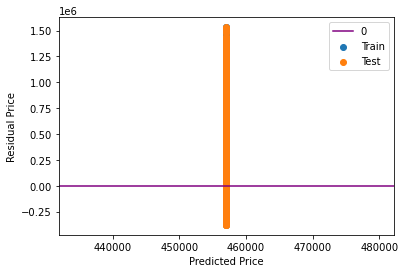

QQ Plot of residuals:


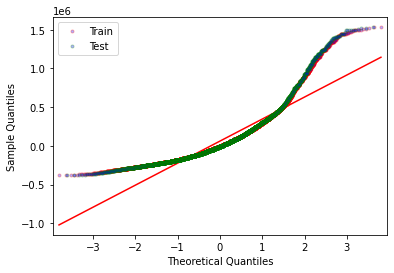

In [898]:
evaluate(y_train, y_test, baseline_train_pred, baseline_test_pred)

### Shit model

In [899]:
def smols(X,y,cols=None):
    Xcol = X[cols]
    shmod = sm.OLS(endog=y, exog=sm.add_constant(Xcol)).fit()
    return shmod

In [900]:
cols = ['sqft_living_log']
smols(X_train,y_train,cols).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                 1.082e+04
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:23:22   Log-Likelihood:                -6223.6
No. Observations:               14211   AIC:                         1.245e+04
Df Residuals:                   14209   BIC:                         1.247e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.0932      0.057    124.023      0.000       6.981       7.205
sqft_living_log     0.7875      0.008    104.004      0.000       0.773       0.802
==============================================================================
Omnibus:                      118.957   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.117
Skew:                           0.020   Prob(JB):                     6.61e-18
Kurtosis:                       2.637   Cond. No.                         140.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [901]:
def linpreds(X_tr_scaled, y_tr, X_te_scaled):
    '''
    Uses Linear Regression to generate output predictions given training and test inputs.
    Arguments:
    X_tr_scaled - dataframe
        Input variables and values for the training set
    y_tr - array-like
        Actual values for output variable, for the training set
    X_te_scaled - dataframe
        Input variables and values for the test set
    Returns:
    Output (y) prediction arrays:
        train, test
    '''
    lr = LinearRegression()
    lr.fit(X_tr_scaled, y_tr)
    return lr.predict(X_tr_scaled), lr.predict(X_te_scaled)

In [902]:
X_train_scaled.columns

Index(['sqft_living', 'sqft_living_log', 'sqft_lot', 'sqft_lot_log',
       'sqft_above', 'sqft_above_log', 'has_basement', 'bedrooms', 'bathrooms',
       'floors', 'Cond_Good', 'Cond_Poor', 'G_Above_Ave', 'G_Excellent',
       'G_Low', 'bedroom/sqft_living_log', 'bathrooms/sqft_living_log',
       'floors/sqft_living_log', 'has_basement*sqft_living_log',
       'sqft_living_log/sqft_lot_log'],
      dtype='object')

### First $&(@# Model

Before going too far down the data preparation rabbit hole, be sure to check your work against a first 'substandard' model! What is the easiest way for you to find out how hard your problem is?

In [903]:
# code here for your first 'substandard' model

In [904]:
# code here to evaluate your first 'substandard' model

In [905]:
smols(X_train_scaled,y_train,\
      cols=['sqft_living_log']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                 1.082e+04
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:23:23   Log-Likelihood:                -6223.6
No. Observations:               14211   AIC:                         1.245e+04
Df Residuals:                   14209   BIC:                         1.247e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              13.0325      0.003   4143.352      0.000      13.026      13.039
sqft_living_log     0.3271      0.003    104.004      0.000       0.321       0.333
==============================================================================
Omnibus:                      118.957   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.117
Skew:                           0.020   Prob(JB):                     6.61e-18
Kurtosis:                       2.637   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

In [906]:
# code here to iteratively improve your models

In [907]:
# code here to evaluate your iterations

In [908]:
smols(X_train_scaled,y_train,\
      cols=['sqft_living_log','G_Above_Ave', 'G_Excellent', 'G_Low']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     3607.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:23:23   Log-Likelihood:                -5265.2
No. Observations:               14211   AIC:                         1.054e+04
Df Residuals:                   14206   BIC:                         1.058e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              13.0325      0.003   4431.944      0.000      13.027      13.038
sqft_living_log     0.2007      0.004     48.627      0.000       0.193       0.209
G_Above_Ave         0.1161      0.004     32.270      0.000       0.109       0.123
G_Excellent         0.1497      0.004     40.799      0.000       0.143       0.157
G_Low              -0.0417      0.003    -12.532      0.000      -0.048      -0.035
==============================================================================
Omnibus:                       44.485   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.171
Skew:                           0.071   Prob(JB):                     5.14e-09
Kurtosis:                       2.790   Cond. No.                         2.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [909]:
def stepwise_selection(X_tr, y_tr, X_te=None, y_te=None,
                       initial_list=[], no_use=[], 
                       verbose=True):
    """
    Perform a forward-backward feature selection 
    based on R2 from sklearn
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        X_tr - pandas.DataFrame with training candidate features
        y_tr - list-like with the training target
        X_te - pandas.DataFrame with test candidate features
        y_te - list-like with the test target
        initial_list - list of features to start with (column names of X_tr)
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    """
    included = list(set(initial_list))
    while True:
        changed=False
        # forward step with R2
        # add feature if the resulting test R2 >= previous test R2
        on_hold = []
        excluded = list(set(X_tr.columns)-set(no_use)-set(included)-set(on_hold))
        new_r2 = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            trpred, tepred = linpreds(X_tr[included+[new_column]], y_tr, 
                                      X_te[included+[new_column]])
            new_r2[new_column] = r2_score(y_te, tepred)
        best_r2 = new_r2.max()
        if best_r2 > r2_score(y_te, tepred):
            best_feature = new_r2.idxmax()
            included.append(best_feature)
            try:
                on_hold.pop()
            except:
                pass
            changed=True
            if verbose:
                print('Add  {:30} with r2: {:.6}'.format(best_feature, best_r2))

        # backward step with RMSE
        trpred, tepred = linpreds(X_tr[included], y_tr, X_te[included])
        y_te_unl, tepred_unl = np.exp(y_te), np.exp(tepred)
        rmse_pre = mean_squared_error(y_te_unl, tepred_unl, squared=False)
        print('Before removal RMSE: {:.2f}'.format(rmse_pre))
        rmses = pd.Series(index=included, dtype='float64')
        for column in included:
            trpred, tepred = linpreds(X_tr[list(set(included)-set(column))], y_tr, 
                                      X_te[list(set(included)-set(column))])
            y_te_unl, tepred_unl = np.exp(y_te), np.exp(tepred)
            rmses[column] = mean_squared_error(y_te_unl, tepred_unl, squared=False)
        lowest_rmse = rmses.min()
        if lowest_rmse < rmse_pre:
            changed=True
            bad_feature = rmses.idxmin()
            on_hold.append(bad_feature)
            included.remove(bad_feature)
            if verbose:
                print('Drop {:30} with RMSE {:.2f}'.format(bad_feature, lowest_rmse))
        else:
            if verbose:
                print('Keep {:30} with RMSE {:.2f}'.format(best_feature, lowest_rmse))
        if not changed:
            break
    return included

In [910]:
stepwise_selection(X_train_scaled, y_train, X_test_scaled, y_test,  \
                   initial_list=['sqft_living_log','G_Low','G_Excellent','G_Above_Ave'], 
                   no_use=['sqft_living_log/sqft_lot_log','sqft_living','sqft_lot',
                           'sqft_above','has_basement*sqft_living_log'])

Add  Cond_Good                      with r2: 0.504756
Before removal RMSE: 202681.79
Keep Cond_Good                      with RMSE 202681.79
Add  sqft_lot_log                   with r2: 0.513473
Before removal RMSE: 200277.46
Keep sqft_lot_log                   with RMSE 200277.46
Add  has_basement                   with r2: 0.518907
Before removal RMSE: 199179.30
Keep has_basement                   with RMSE 199179.30
Add  bedroom/sqft_living_log        with r2: 0.52314
Before removal RMSE: 198474.70
Keep bedroom/sqft_living_log        with RMSE 198474.70
Add  bedrooms                       with r2: 0.528462
Before removal RMSE: 197571.46
Keep bedrooms                       with RMSE 197571.46
Before removal RMSE: 197571.46
Keep bedrooms                       with RMSE 197571.46


['G_Above_Ave',
 'G_Excellent',
 'G_Low',
 'sqft_living_log',
 'Cond_Good',
 'sqft_lot_log',
 'has_basement',
 'bedroom/sqft_living_log',
 'bedrooms']

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [911]:
# code here to show your final model

In [912]:
# code here to evaluate your final model

In [913]:
relcol = ['has_basement*sqft_living_log',
 'Cond_Good',
 'sqft_lot_log',
 'bedroom/sqft_living_log',
 'G_Above_Ave',
 'G_Excellent',
 'G_Low',
 'bedrooms',
 'sqft_above_log']
smols(X_train_scaled, y_train, cols=relcol).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     1810.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:23:27   Log-Likelihood:                -4816.2
No. Observations:               14211   AIC:                             9652.
Df Residuals:                   14201   BIC:                             9728.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           13.0325      0.003   4573.416      0.000      13.027      13.038
has_basement*sqft_living_log     0.0741      0.005     16.167      0.000       0.065       0.083
Cond_Good                        0.0526      0.003     17.617      0.000       0.047       0.058
sqft_lot_log                    -0.0340      0.003    -10.849      0.000      -0.040      -0.028
bedroom/sqft_living_log         -0.7034      0.037    -19.235      0.000      -0.775      -0.632
G_Above_Ave                      0.1127      0.004     30.326      0.000       0.105       0.120
G_Excellent                      0.1473      0.004     38.589      0.000       0.140       0.155
G_Low                           -0.0477      0.003    -14.638      0.000      -0.054      -0.041
bedrooms                         0.7537      0.040     18.691      0.000       0.675       0.833
sqft_above_log                   0.0792      0.008      9.499      0.000       0.063       0.096
==============================================================================
Omnibus:                        1.173   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.556   Jarque-Bera (JB):                1.171
Skew:                           0.022   Prob(JB):                        0.557
Kurtosis:                       3.000   Cond. No.                         32.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [914]:
relcol = ['has_basement',
 'Cond_Good',
 'sqft_lot_log',
 'bedroom/sqft_living_log',
 'bedrooms',
 'G_Above_Ave',
 'G_Excellent',
 'G_Low',
 'sqft_above_log']
smols(X_train_scaled, y_train, cols=relcol).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     1808.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:23:27   Log-Likelihood:                -4820.1
No. Observations:               14211   AIC:                             9660.
Df Residuals:                   14201   BIC:                             9736.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      13.0325      0.003   4572.155      0.000      13.027      13.038
has_basement                0.0721      0.005     15.919      0.000       0.063       0.081
Cond_Good                   0.0529      0.003     17.722      0.000       0.047       0.059
sqft_lot_log               -0.0337      0.003    -10.760      0.000      -0.040      -0.028
bedroom/sqft_living_log    -0.7233      0.036    -20.097      0.000      -0.794      -0.653
bedrooms                    0.7762      0.040     19.581      0.000       0.699       0.854
G_Above_Ave                 0.1128      0.004     30.363      0.000       0.106       0.120
G_Excellent                 0.1474      0.004     38.619      0.000       0.140       0.155
G_Low                      -0.0476      0.003    -14.580      0.000      -0.054      -0.041
sqft_above_log              0.0769      0.008      9.258      0.000       0.061       0.093
==============================================================================
Omnibus:                        1.381   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.501   Jarque-Bera (JB):                1.377
Skew:                           0.024   Prob(JB):                        0.502
Kurtosis:                       3.002   Cond. No.                         31.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Train R2 score: 0.5418556606542508 
Test R2 score: 0.5356466236879424 
<><><><><>
Train RMSE: $192,598.76 
Test RMSE: $197,445.58 
<><><><><>
Train MAE: $136,422.95 
Test MAE: $138,592.11 

Scatter of residuals:


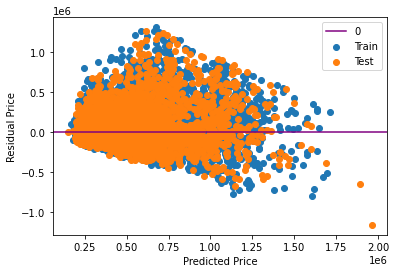

QQ Plot of residuals:


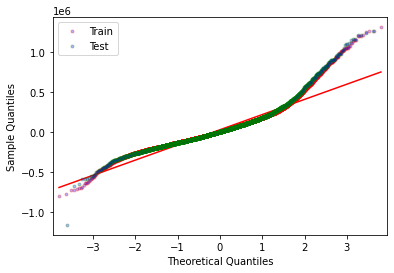

In [915]:
Xftr, Xfte = X_train_scaled[relcol], X_test_scaled[relcol]
trp, tep = linpreds(Xftr, y_train, Xfte)
evaluate(y_train, y_test, trp, tep)

In [953]:
smols(X_test, y_test, cols=relcol).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     875.5
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        13:02:30   Log-Likelihood:                -2488.7
No. Observations:                7000   AIC:                             4997.
Df Residuals:                    6990   BIC:                             5066.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      12.0818      0.218     55.300      0.000      11.653      12.510
has_basement                0.1459      0.014     10.644      0.000       0.119       0.173
Cond_Good                   0.1301      0.009     14.323      0.000       0.112       0.148
sqft_lot_log               -0.0500      0.005     -9.645      0.000      -0.060      -0.040
bedroom/sqft_living_log    -7.2583      0.498    -14.586      0.000      -8.234      -6.283
bedrooms                    0.9069      0.064     14.111      0.000       0.781       1.033
G_Above_Ave                 0.2206      0.011     20.273      0.000       0.199       0.242
G_Excellent                 0.5949      0.022     27.239      0.000       0.552       0.638
G_Low                      -0.1443      0.015     -9.518      0.000      -0.174      -0.115
sqft_above_log              0.1824      0.029      6.260      0.000       0.125       0.240
==============================================================================
Omnibus:                        4.325   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.115   Jarque-Bera (JB):                4.350
Skew:                           0.054   Prob(JB):                        0.114
Kurtosis:                       2.944   Cond. No.                     1.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [954]:
np.exp(0.9069)

2.476633058375575

In [948]:
np.exp(0.9069)

2.476633058375575

In [947]:
np.exp(11.9118+0.9069) - np.exp(11.9118)

220039.97988294598

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
